In [3]:
from anomaly_detection import detect_anomaly, synthetic_data
from pylab import *
import matplotlib.pyplot as plt

import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
import pandas as pd
import numpy as np

Import synthetic data

In [39]:
n_cluster = 5
n_features = 2
mean = np.array([[-2,  2, -1,  0,  0],
        [-1,  1,  1,  2, -1]])
cov = np.repeat([0.01*np.ones([n_features,n_features])], n_cluster).reshape(n_features, n_features, n_cluster)

In [40]:
cov.shape, mean.shape

((2, 2, 5), (2, 5))

In [41]:
data = synthetic_data.generateClusters(n_cluster, mean, cov, \
            n_features)

In [43]:
X, y = data.generate_data()

In [59]:
X_ = np.hstack(X).T
y_ = np.hstack(y).reshape(-1,1)
data_arr = np.concatenate([X_,y_], axis=1)
data_df = pd.DataFrame(data_arr, columns=['f1','f2','cl'])
data_df.cl = data_df.cl.astype(int)

Discretization

In [60]:
disc=6 # Disc(retization) may be between 2 and 9
r=np.array(range(disc+1))/(1.0*disc)

# quantiles are building using pandas.qcut
# The "class" column is just copied.
l=[]
for col in data_df.columns.values:
    if col!="cl":
        l.append(pd.DataFrame(pd.qcut(data_df[col],r),columns=[col]))
    else:
        l.append(pd.DataFrame(data_df[col],columns=[col]))
treated=pd.concat(l, join='outer', axis=1)

treated.to_csv("clTreated.csv",index=False)
treated.head()

,f1,f2,cl
0,"(-2.291, -1.91]","(-1.017, -0.908]",0
1,"(0.0529, 1.889]","(-0.908, 0.916]",1
2,"(-0.97, -0.0547]","(1.032, 1.907]",2
3,"(-0.0547, 0.0529]","(1.907, 2.305]",3
4,"(-0.0547, 0.0529]","(-1.017, -0.908]",4


Learned in 0.29543ms


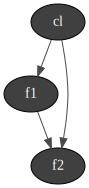

In [61]:
learner=gum.BNLearner("clTreated.csv")
learner.useLocalSearchWithTabuList()
bn_cl=learner.learnBN()
print("Learned in {0}ms".format(1000*learner.currentTime()))
gnb.showBN(bn_cl)

In [62]:
bn_cl.cpt('cl')

(pyAgrum.Potential<double>@0x55ab32c1e8e0) 
  cl                                             |
0        |1        |2        |3        |4        |
---------|---------|---------|---------|---------|
 0.2000  | 0.2000  | 0.2000  | 0.2000  | 0.2000  |

In [66]:
bn_cl.cpt('f1')

(pyAgrum.Potential<double>@0x55ab328977f0) 
      ||  f1                                                       |
cl    ||(-0.0547,|(-0.97, -|(-1.91, -|(-2.291, |(0.0529, |(1.889, 2|
------||---------|---------|---------|---------|---------|---------|
0     || 0.0003  | 0.0003  | 0.1600  | 0.8387  | 0.0003  | 0.0003  |
1     || 0.0003  | 0.0003  | 0.0003  | 0.0003  | 0.1600  | 0.8387  |
2     || 0.0003  | 0.3297  | 0.6690  | 0.0003  | 0.0003  | 0.0003  |
3     || 0.4295  | 0.2199  | 0.0003  | 0.0003  | 0.3496  | 0.0003  |
4     || 0.3995  | 0.2798  | 0.0003  | 0.0003  | 0.3197  | 0.0003  |

In [65]:
ie=gum.LazyPropagation(bn_cl)
ie.setEvidence({'f1':'(-1.91, -0.97]', 'f2': '(-1.017, -0.908]'})
ie.makeInference()
ie.posterior("cl")

(pyAgrum.Potential<double>@0x55ab32f6b0a0) 
  cl                                             |
0        |1        |2        |3        |4        |
---------|---------|---------|---------|---------|
 0.9784  | 0.0054  | 0.0054  | 0.0054  | 0.0054  |

Quasi Continuous

BN{nodes: 2, arcs: 1, domainSize: 600, dim: 599, mem: 4Ko 720o}


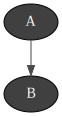

In [68]:
minB,maxB=-3,3
minC,maxC=4,14
NB=300
bn=gum.BayesNet("Quasi-Continuous")
bn.add(gum.LabelizedVariable("A","A binary variable",2))
bn.add(gum.NumericalDiscreteVariable("B","A range variable",minB,maxB,NB))
bn.addArc("A","B")
print(bn)
gnb.showBN(bn)


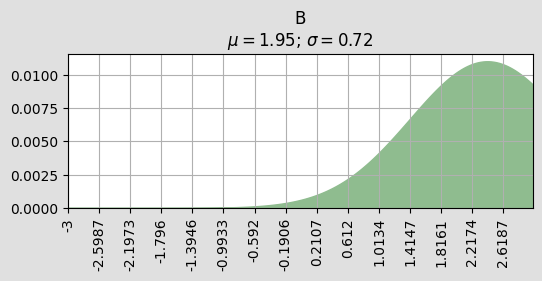
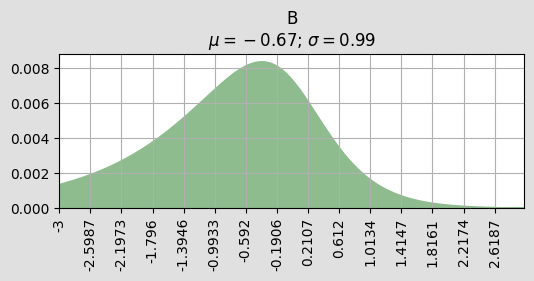

In [69]:
def normalize(rv,vmin,vmax,size):
    pdf=rv.pdf(linspace(vmin,vmax,size))
    return (pdf/sum(pdf))

from scipy.stats import norm,genhyperbolic
p, a, b = 0.5, 1.5, -0.7
bn.cpt("B")[{'A':0}]=normalize(norm(2.41),minB,maxB,NB)
bn.cpt("B")[{'A':1}]=normalize(genhyperbolic(p,a,b),minB,maxB,NB)
gnb.flow.clear()
gnb.flow.add(gnb.getProba(bn.cpt("B").extract({"A":0})),caption="P(B|A=0)")
gnb.flow.add(gnb.getProba(bn.cpt("B").extract({"A":1})),caption="P(B|A=1)")
gnb.flow.display()